In [1]:
import os, glob, copy
import numpy as np
import nrrd, scipy
import matplotlib.pyplot as plt
import plotting_help_py37 as ph
import orn_pn_matching_imaging as im
import orn_pn_matching as opm
import tifffile as tiff
from skimage import measure
import matplotlib.gridspec as gridspec
from matplotlib import animation
from IPython import display
import matplotlib as mpl 
from scipy import ndimage
from matplotlib import rcParams

mpl.rcParams['animation.ffmpeg_path'] = '../ffmpeg'
rcParams['text.usetex'] = True
plt.rcParams.update({'text.usetex': True})
import warnings
warnings.filterwarnings("ignore")

In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [4]:
gts = [
    'OB-1-atonal','OB-2-amos', 'OB-3-MP', 'OB-4-VC3', 'OB-6-DM6', 'OB-7-VA1d', 'OB-8-DL4',
#     'OB-9-DC4',
      ]
labels = gts
colors = ph.colors_high_contrast()
parent_folder = '../../../1_Data/confocal/2_ORN_exps/Traj/Traj_WT/'

recss = []
for gt in gts:
    recs = im.get_recs_Vertical(gt, parent_folder=parent_folder, multifolders=True,)
    recss.append(recs)

In [88]:
len(gts)

7

In [5]:
yss, ts, rs = im.get_yss_from_recss(recss, zero_baseline=True, ch=0, ntheta=27, nr=20, rmax=40)

In [124]:
for rec in recss[0]:
    print(rec.fn)

OB-9-DC4-mGLx2-26hAPF-3.tif-lobeside_1
OB-9-DC4-mGLx2-26hAPF-3.tif-lobeside_0


Text(0, 0.5, 'density')

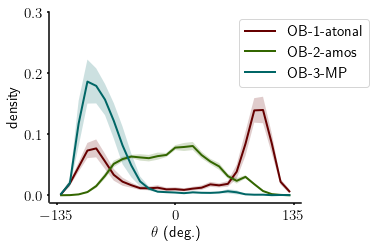

In [7]:
ax = ph.large_ax([4.5,3.5])
ph.set_fontsize(15)
for i, ys in enumerate(yss[:3]):
    ym = np.nanmean(ys, axis=0)
    ysem = scipy.stats.sem(ys, axis=0)
    ax.plot(np.degrees(ts), ym, c=colors[i], lw=2, label=labels[i])
    ax.fill_between(np.degrees(ts), ym-ysem, ym+ysem, facecolor=colors[i], edgecolor='none', alpha=.2)
ax.legend(fontsize=15, loc='upper right', bbox_to_anchor=(1.3,1))
ph.adjust_spines(ax, ['left','bottom'],lw=1.5)
ax.set_yticks([0,.1,.2,.3])
ax.set_xticks([-135,0,135])
ax.set_xlabel(r'$\theta$ (deg.)')
ax.set_ylabel('density')
# ph.save('Distribution-ORN', exts=['png',])

Text(0, 0.5, 'density')

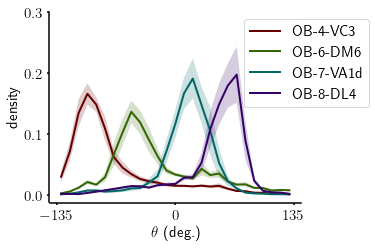

In [9]:
ax = ph.large_ax([4.5,3.5])
ph.set_fontsize(15)
for i, ys in enumerate(yss[3:]):
    ym = np.nanmean(ys, axis=0)
    ysem = scipy.stats.sem(ys, axis=0)
    ax.plot(np.degrees(ts), ym, c=colors[i], lw=2, label=labels[i+3])
    ax.fill_between(np.degrees(ts), ym-ysem, ym+ysem, facecolor=colors[i], edgecolor='none', alpha=.2)
ax.legend(fontsize=15, loc='upper right', bbox_to_anchor=(1.3,1))
ph.adjust_spines(ax, ['left','bottom'],lw=1.5)
ax.set_yticks([0,.1,.2,.3])
ax.set_xticks([-135,0,135])
ax.set_xlabel(r'$\theta$ (deg.)')
ax.set_ylabel('density')
# ph.save('Distribution-ORN', exts=['png',])

### Individual

In [ ]:
ato [0][4]
amos [1][0]
MP [2][8]
VC3 [3][2]
DM6 [4][9]
VA1d [5][8]
DL4 [6][11]

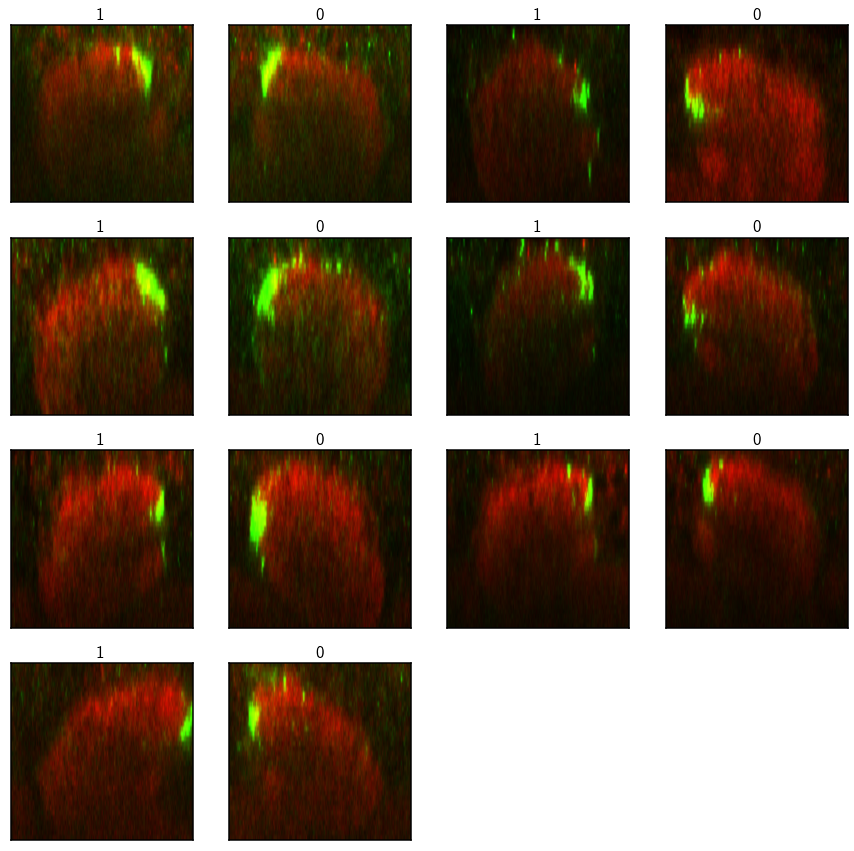

In [83]:
plt.figure(1, (15,15))
gs = gridspec.GridSpec(4, 4)

recs = recss[6]
for i in range(len(recs)):
    rec = recs[i]
    row = int(i / 4)
    col = int(i % 4)
    ax = plt.subplot(gs[row, col])
    im.plot_single_verticalsection(rec, chs=[0,1], RGB_chs=[1,0,2], RGB_factors=[1,1,1],
                                   istep=50, window_halfwidth_ratio=1.5)

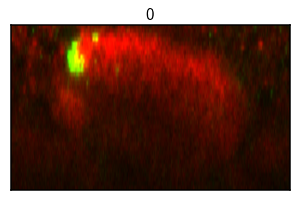

In [86]:
im.plot_single_verticalsection(recss[6][11], chs=[0,1], RGB_chs=[1,0,2], RGB_factors=[1.5,1,1],
                                   istep=50, window_halfwidth_ratio=1.5)

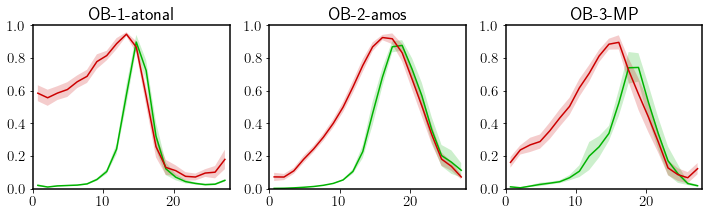

In [53]:
plt.figure(1, (12, 3))
gs = gridspec.GridSpec(1, 3)
thresh = 0.2

for col in range(3):
    recs = recss[col]
    yso, ysn = [], []
    for rec in recs:
        Ms, ts, rs, Mr, Mtheta = rec.get_vertical_Matrix([0,1], istep=50, window_halfwidth_ratio=1.5,
                                                                     ntheta=27, nr=20, rmax=28, )
        # inds_ts = (ts>-np.pi/2) & (ts<0)
        idxs = (np.nanmax(Ms[0], axis=1) > thresh)
        yo = np.nanmean(Ms[0][idxs, :], axis=0)
        yn = np.nanmean(Ms[1][idxs, :], axis=0)
        yso.append((yo-np.nanmin(yo)) / (np.nanmax(yo)-np.nanmin(yo)))
        ysn.append((yn-np.nanmin(yn)) / (np.nanmax(yn)-np.nanmin(yn)))

    ax = plt.subplot(gs[0, col])
    n = len(recs)
    yso = np.array(yso)
    ysn = np.array(ysn)
    yo_sem = np.nanstd(yso, axis=0) / np.sqrt(n)
    yn_sem = np.nanstd(ysn, axis=0) / np.sqrt(n)
    yo_m = np.nanmean(yso, axis=0)
    yn_m = np.nanmean(ysn, axis=0)
    ax.plot(rs, yo_m, c=ph.green)
    ax.plot(rs, yn_m, c=ph.red)
    ax.fill_between(rs, yo_m-yo_sem, yo_m+yo_sem, facecolor=ph.green, edgecolor='none', alpha=.2)
    ax.fill_between(rs, yn_m-yn_sem, yn_m+yn_sem, facecolor=ph.red, edgecolor='none', alpha=.2)
    ax.set_xlim(0,28)
    ax.set_ylim(0,1)
    ax.set_title(gts[col])

In [13]:
rec = recss[2][0]

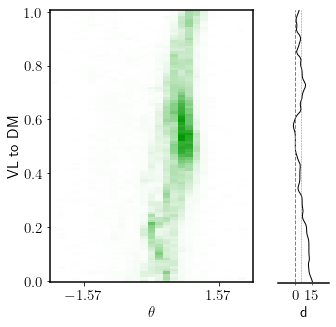

In [14]:
im.plot_heatmap_distance(rec, ch_heatmap=0, chs_dist=[0,1])

In [15]:
rec = recss[3][0]

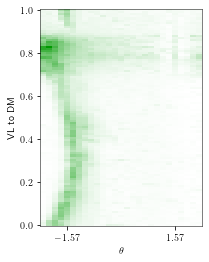

In [24]:
for i in [0,1,2,3,4]:
    rec = recss[i][0]
    im.plot_heatmap_distance(rec, ch_heatmap=0, chs_dist=[0,1], cmap=ph.Greens, heatmap_only=True,)
    ph.save('ORN_single-' + labels[i] + '-RG', exts=['png',])

In [20]:
a = ['adf' + 'adfa']
print(a)

['adfadfa']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


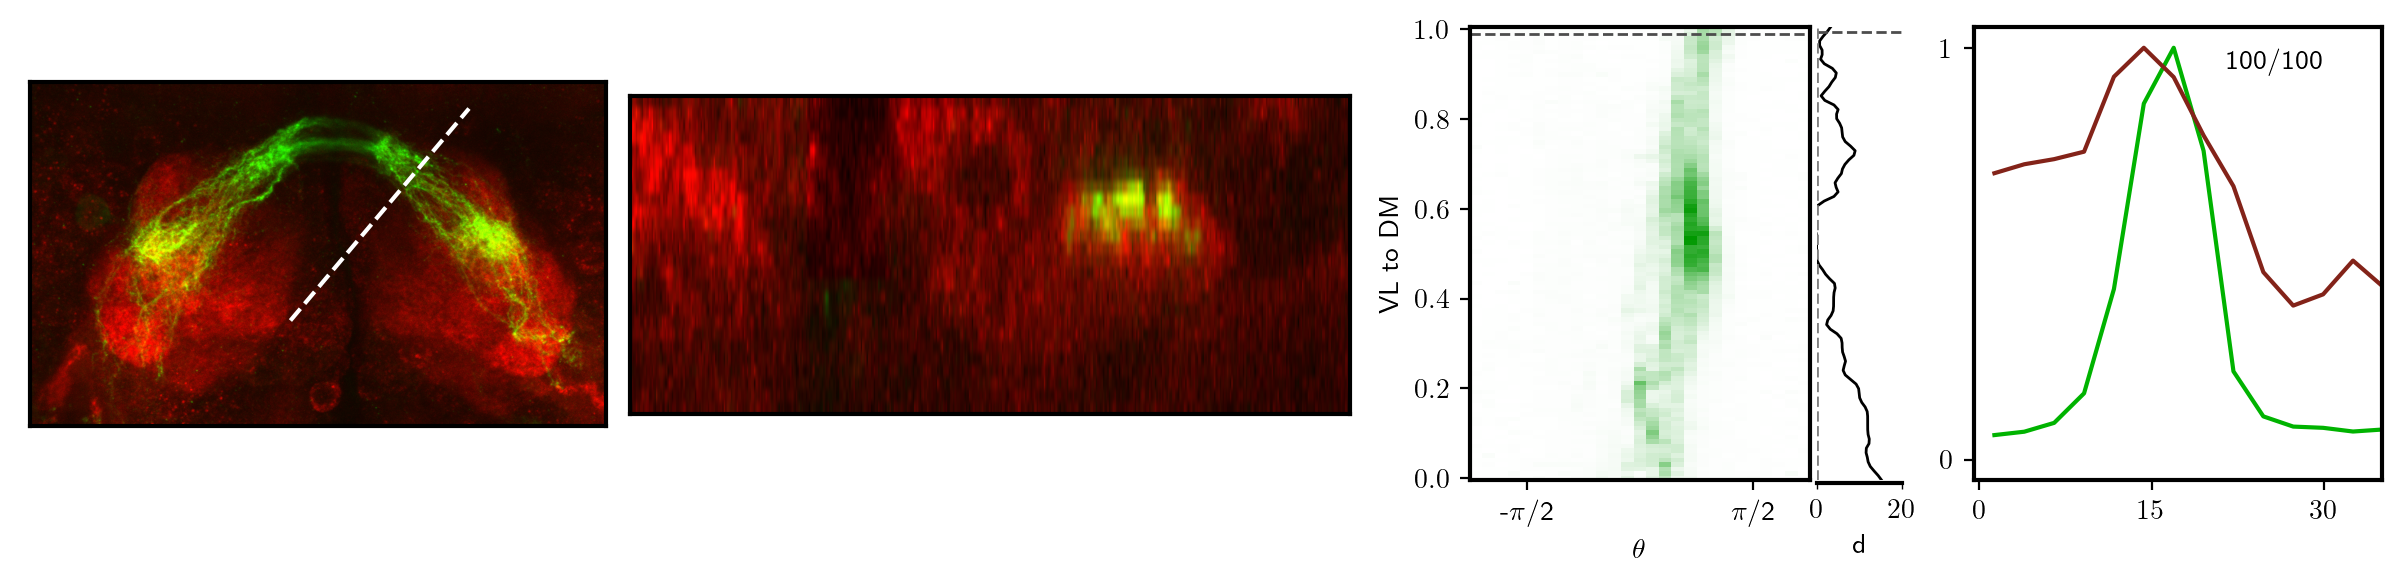

In [37]:
for i in [2,]:
    rec = recss[i][0]
    im.makemovie_verticalAL_2mv(rec, chs=[0,1], RGB_chs=[1,0,2], RGB_factors_maxi=[1.5,1.5,1.5],
                                RGB_factors=[1.3,1,1.3], ch_heatmap=0, cmap=ph.Greens, chs_dist=[0,1], 
                                dline_cs=[ph.green, ph.dred], fs=10, factor_G=1,
                                Nframes=100, dpi=200, moviename=('./saves/ORN_single-' + labels[i] + '-RG'),)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


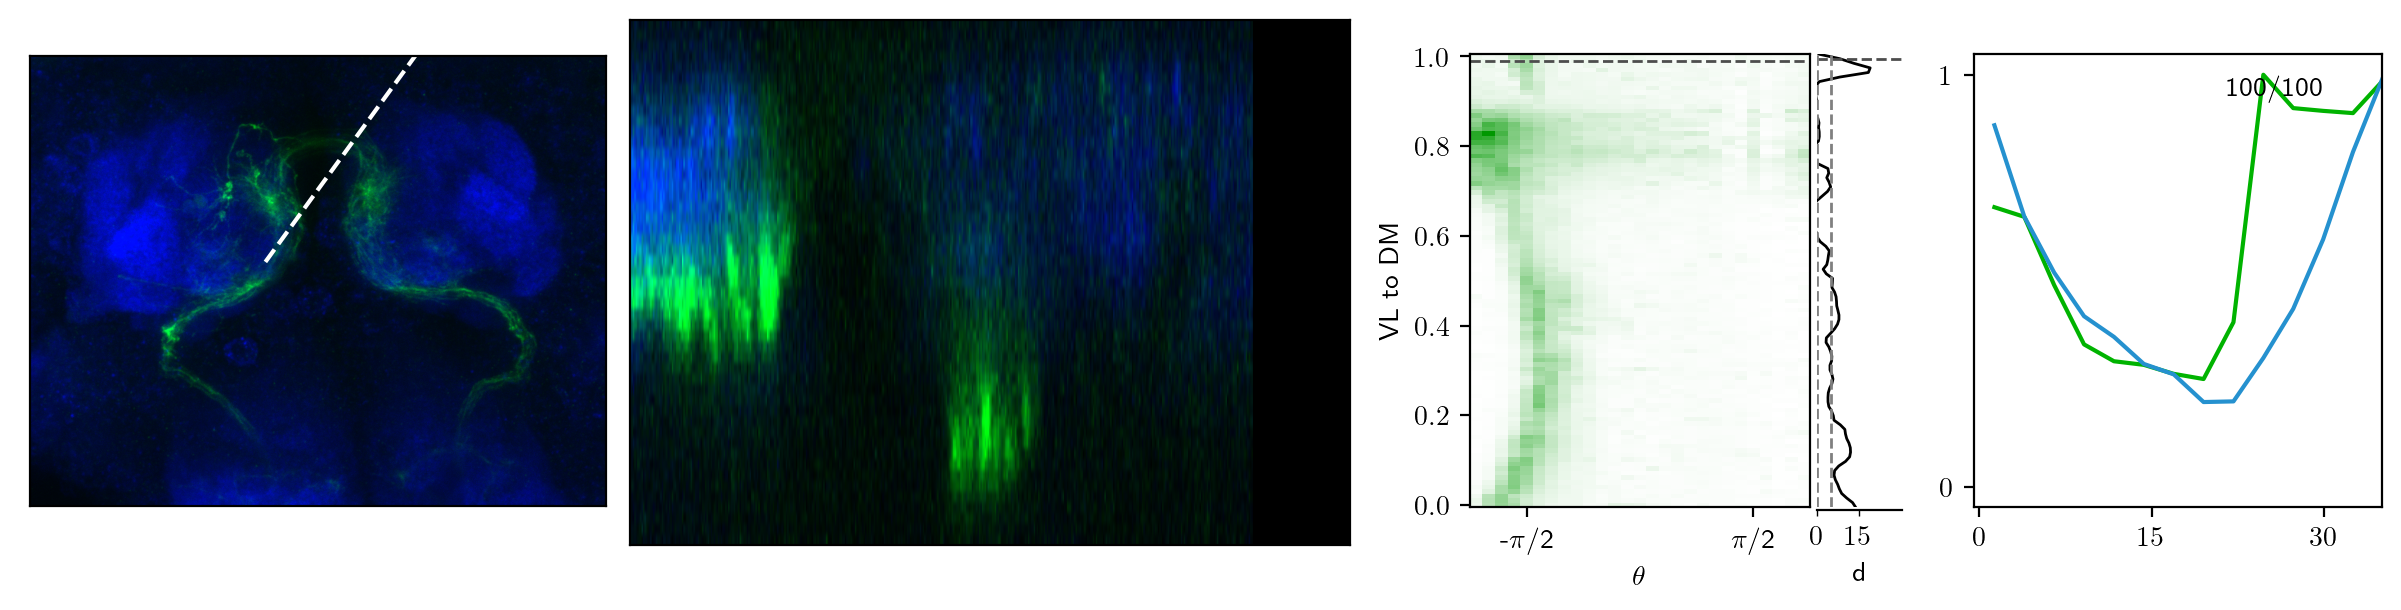

In [7]:
im.makemovie_verticalAL_2mv(rec, chs=[0,1], RGB_chs=[1,0,2], RGB_factors_maxi=[1.5,1.5,1.5],
                            RGB_factors=[1.3,1,1.3], ch_heatmap=0, cmap=ph.Greens, chs_dist=[0,1], 
                            dline_cs=[ph.green, ph.dred], 
                            Nframes=100, dpi=200, moviename='./saves/MP-16H04-RG', fs=10, factor_G=1)

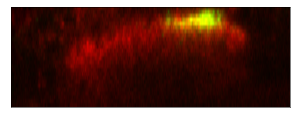

In [28]:
rec = recss[2][0]
im.plot_single_verticalsection(rec, chs=[0,1], RGB_chs=[1,0,2], RGB_factors=[1.1,.6,1.5],
                               istep=60, window_halfwidth_ratio=1.5)
ph.save('af', exts=['png'])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


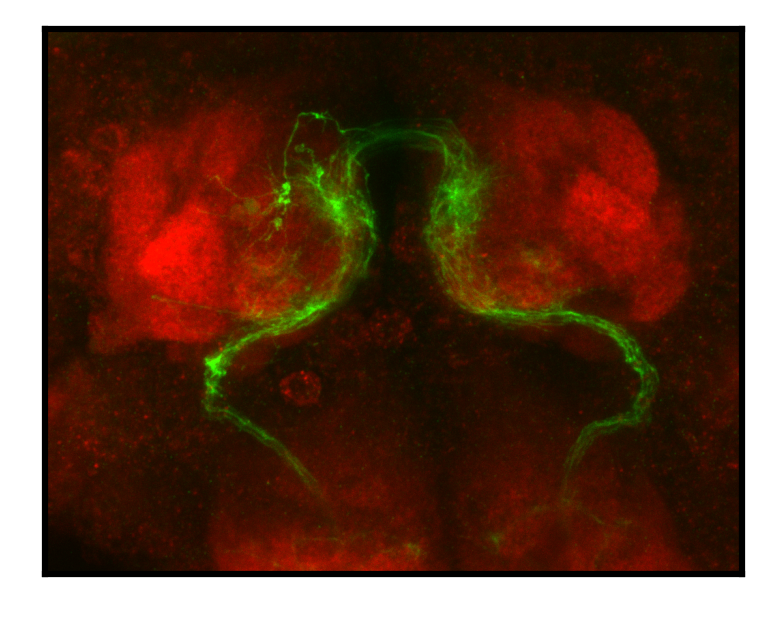

In [36]:
for i in [0,1,2,3,4]:
    rec = recss[i][0]
    im.plot_single_maxiprojection(rec, chs=[0,1], RGB_chs=[1,0,2], RGB_factors_maxi=[1.5,2,1], dpi=300)
    ph.save('MaxiP-ORN_single-' + labels[i] + '-RG', exts=['png',])

In [48]:
chs=[0,1]
ch_heatmap=0
RGB_chs=[1,0,2]
chs_dist=[0,1]
RGB_factors=[1,1,1]

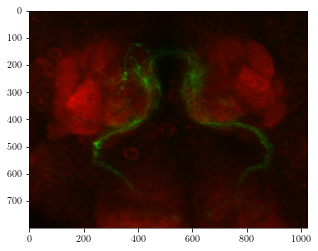

In [53]:
imgR = np.nanmax(rec.tifs[:, :, :, RGB_chs[0]], axis=-1) if RGB_chs[0] < len(chs) else np.zeros_like(rec.tifs[:, :, 0, 0])
imgG = np.nanmax(rec.tifs[:, :, :, RGB_chs[1]], axis=-1) if RGB_chs[1] < len(chs) else np.zeros_like(rec.tifs[:, :, 0, 0])
imgB = np.nanmax(rec.tifs[:, :, :, RGB_chs[2]], axis=-1) if RGB_chs[2] < len(chs) else np.zeros_like(rec.tifs[:, :, 0, 0])
ones = np.full_like(imgG, 1)
imgR = imgR / np.max(imgR)
imgG = imgG / np.max(imgG)
img_RGB = np.dstack([imgR * RGB_factors[0], imgG * RGB_factors[1], imgB * RGB_factors[2]])
plt.imshow(img_RGB)

In [49]:
RGB_factors=[1,1,1.3]
imgs = [[],[]]
for istep in np.arange(1,100,2).astype(int):
    imgs_, zx_ratio = rec.get_vertical_img(chs=[0,1], istep=istep, window_halfwidth_ratio=1.5)
    for i in range(2):
        imgs[i].append(imgs_[i][::-1, :])
        
imgG = np.max(np.array(imgs[0]), axis=0)
imgR = np.max(np.array(imgs[1]), axis=0)
imgB = np.zeros_like(imgG)
img_RGB = np.dstack([imgR * RGB_factors[0], imgG * RGB_factors[1], imgB * RGB_factors[2]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


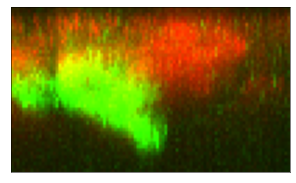

In [50]:
fig = plt.figure(1, [5, 5 * zx_ratio])
_ = plt.xticks([])
_ = plt.yticks([])
_ = plt.imshow(img_RGB, aspect='auto')